In [1]:
from scipy import io
from pathlib import Path

import numpy as np
rng = np.random.default_rng()

import jax.numpy as jnp
import jax.random as jr

import optax

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import ET_HMM, E_HMM, T_HMM, CircularRegressionBiasedHMM
from dynamax.utils.plotting import gradient_cmap

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Utility

In [2]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink",
    "greyish",
    "light blue",
    "green",
    "yellow",
]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
def plot_emissions_and_states(emissions, design, most_likely_states, posterior, cmap, colors):
    # print("emmissions shape", emissions.shape)
    # print("design shape", design.shape)

    emission_dim = emissions.shape[-1]
    time_bins = emissions.shape[0]
    state_probability_spread = posterior.smoothed_probs.T
    lim = 1.1 * max(abs(emissions).max(), 1)

    plt.figure(figsize=(12, 10))
    plt.suptitle("Emissions and Inferred States", y=1.01)

    # Plot number 1
    plt.subplot(311)

    im = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, 0, np.pi)
    )

    values = np.unique(most_likely_states.ravel())
    colors_x = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors_x[i], label=f"State {values[i] + 1}") for i in range(len(values)) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Most Likely Z")

    # emissions line
    for d in range(emission_dim):
        plt.plot(emissions[:,d], '-ko')

    plt.yticks(ticks=[0, np.pi/2, np.pi], labels=[0, "$\pi/2$", "$\pi$"])


    # Plot number 2
    plt.subplot(312)
    im2 = plt.imshow(most_likely_states[None, :],
        aspect="auto",
        cmap=cmap,
        vmin=0,
        vmax=len(colors) - 1,
        extent=(0, time_bins, 0, np.pi)
    )

    # plt.plot(design, '-ko')
    # plot this but each line is a different color
    # line_colors = ["red", "blue", "green", "orange"]
    # Rare colors
    line_colors = ["#FF5733", "#33FF57", "#5733FF", "#528003", "#FF33E6"]
    for line in range(design.shape[1]):
        plt.plot(design[:, line], '--x', color=line_colors[line])

    plt.legend(["Target", "Focused", "High Coh", "Expc"], bbox_to_anchor=(1.05, 1))

    plt.yticks(ticks=[0, np.pi/2, np.pi], labels=[0, "$\pi/2$", "$\pi$"])


    # Plot number 3
    plt.subplot(313)
    plt.imshow(state_probability_spread, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
    plt.ylabel("$z_{\\mathrm{inferred}}$")
    plt.yticks(ticks=range(state_probability_spread.shape[0]), labels=np.array(range(state_probability_spread.shape[0])) + 1)
    plt.xlabel("time")

    plt.show()
    # plt.savefig("factors_affecting.eps", format="eps")

def plot_lps(lps): 
    plt.figure(figsize=(6, 3))
    # true_lp = true_arhmm.marginal_log_prob(true_params, emissions, inputs=inputs)
    plt.plot(lps, label="EM")
    # plt.plot(true_lp * jnp.ones(len(lps)), ':k', label="True")
    plt.xlabel("EM Iteration")
    plt.ylabel("Log Probability")
    plt.legend(loc="lower right")
    plt.show()

def plot_validation(cross_valids, show_var = True, max_states = 7):
    avg_val_lls = cross_valids.mean(axis=1)
    plt.plot(range(2, max_states), avg_val_lls, '-ko')
    if show_var:
        for k, per_fold_val_lls in zip(range(2, max_states), cross_valids):
            plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
    plt.xticks(range(2, max_states))
    plt.xlabel("num states ($K$)")
    plt.ylabel("avg. validation log prob.")
    # plt.savefig("cross_val.eps", format="eps")
    plt.show()

## Loading Data

In [4]:
design_matrix = np.load("../analysis/cache/exp_design.npy")
observation = np.load("../analysis/cache/exp_obs.npy")

design_matrix.shape, observation.shape

# design_matrix = design_matrix[:260]
# observation = observation[:260]

design_matrix[:,:,0] = np.deg2rad(design_matrix[:,:,0])
design_matrix[:,:,3] = np.deg2rad(design_matrix[:,:,3])

flat_biases = np.ones_like(design_matrix[:,:,:1])
design_matrix =  np.concatenate([design_matrix, flat_biases], axis=-1)

In [5]:



shuff_idx = np.random.permutation(len(design_matrix))

design_matrix = design_matrix[shuff_idx]
observation = observation[shuff_idx]

observation = np.deg2rad(observation)

In [6]:
# Split it 80:20 for training and testing

train_idx = int(0.8 * len(design_matrix))

train_design = design_matrix[:train_idx]
train_obs = observation[:train_idx]

test_design = design_matrix[train_idx:]
test_obs = observation[train_idx:]

In [7]:
train_design.shape, train_obs.shape, test_design.shape, test_obs.shape

((208, 120, 5), (208, 120, 1), (52, 120, 5), (52, 120, 1))

In [8]:
# Repeat training data multiple times and shuffle them

# train_design = np.repeat(train_design, 10, axis=0)
# train_obs = np.repeat(train_obs, 10, axis=0)

# shuff_idx = np.random.permutation(len(train_design))

# train_design = train_design[shuff_idx]
# train_obs = train_obs[shuff_idx]

In [9]:
train_design.shape, train_obs.shape

((208, 120, 5), (208, 120, 1))

In [10]:
# convert to jax
train_emissions = jnp.array(train_obs)
train_inputs = jnp.array(train_design)

## Fitting

In [11]:
def train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs):
    # Initialize with K-Means
    lrhmm = ET_HMM(num_states, input_dim, emission_dim)
    params, props = lrhmm.initialize(key=jr.PRNGKey(1))

    # Fit with EM
    fitted_params, lps = lrhmm.fit_sgd(params, props, train_emissions, num_epochs = 10000 , inputs=train_inputs, optimizer=optax.adam(1e-4), shuffle=False, batch_size=64)
    # fitted_params, lps = lrhmm.fit_em(params, props, train_emissions, num_iters = 200 , inputs=train_inputs)

    return lrhmm, fitted_params, lps

In [12]:
all_models, all_params, all_lps = [], [], []

input_dim = 5
emission_dim = 1

min_state = 2
max_state = 3

for num_states in range(min_state, max_state):
    print(f'Training: {num_states} states')
    arhmm, fitted_params, lps = train_arhmm(num_states, emission_dim, input_dim, train_emissions, train_inputs)
    all_models.append(arhmm)
    all_params.append(fitted_params)
    all_lps.append(lps)


# log_likelihoods.shape (120, 2, 1)
    
# (0.0, Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=6/0)>)
# Traced<ShapedArray(int32[120])>with<DynamicJaxprTrace(level=6/0)>

Training: 2 states


In [13]:
all_lps[0]

Array([1.9825556, 1.980359 , 1.9781661, ..., 1.0841352, 1.0841352,
       1.0841353], dtype=float32)

Text(0, 0.5, 'Loss')

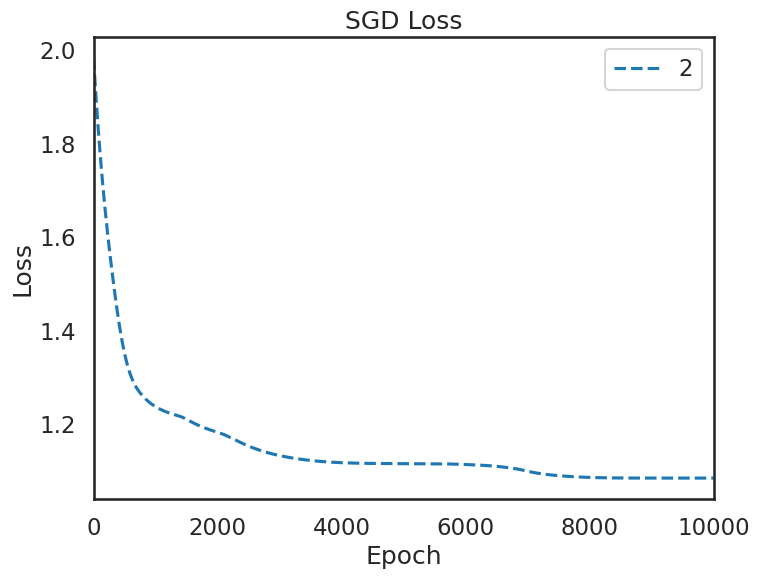

In [14]:
# SGD
plt.figure(figsize=(8, 6))

for x in all_lps:
    plt.plot(x, "--")
plt.legend(range(min_state, max_state))
# plt.ylim(-2, 2)
plt.xlim(0, 10000)
plt.title("SGD Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.savefig("sgd_loss.eps", format="eps")

In [15]:
# for x in all_lps:
#     plt.plot(x, "-")
# plt.legend(range(min_state, max_state))
# # plt.ylim(25000, 37000)
# plt.xlim(0, 200)

# plt.title("Expectation Maximization across states")
# plt.xlabel("Epoch")
# plt.ylabel("Log Likelihood")

In [16]:
def cross_validate(all_models, all_params, emissions, inputs):
    cross_valids = []

    for model_idx in range(len(all_models)):
        print(f'Cross Validating: {model_idx} model')
        state_log_probs = []
        for validation_idx in range(len(emissions)):
            log_prob = all_models[model_idx].marginal_log_prob(all_params[model_idx], emissions[validation_idx], inputs=inputs[validation_idx])
            state_log_probs.append(float(log_prob))
        cross_valids.append(state_log_probs)

    return np.array(cross_valids)

In [17]:
# cross_train = cross_validate(all_models, all_params, train_emissions, train_design)
cross_train = cross_validate(all_models, all_params, test_obs, test_design)


Cross Validating: 0 model


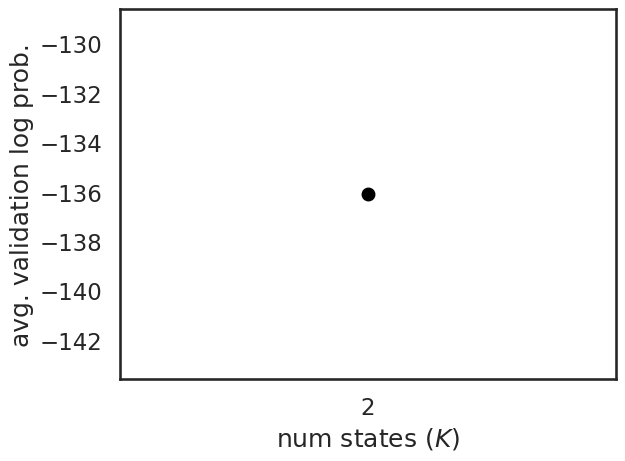

In [18]:
plot_validation(cross_valids=cross_train, show_var=False, max_states=max_state) 

In [19]:
cross_train

array([[-138.48643494, -117.08281708,  -89.31720734, -124.66958618,
        -152.88771057, -178.04905701, -136.81021118, -123.22232056,
        -116.65106964, -141.5750885 ,  -89.84317017, -103.20593262,
        -117.54076385, -109.07196045, -145.90446472, -156.27546692,
        -176.97486877, -124.52042389, -148.10006714, -141.05058289,
        -148.91648865, -121.6023407 ,  -99.63342285, -155.52549744,
        -195.11022949, -152.34526062, -117.79919434, -131.74829102,
        -183.67414856, -113.70204926,  -90.14568329, -103.41968536,
        -135.32409668, -139.26931763, -142.86392212, -107.36914825,
        -130.35096741, -144.99589539, -134.2755127 , -132.13505554,
        -180.85908508, -164.01887512, -122.98738098, -156.73240662,
        -209.89602661, -110.60729218, -120.4900589 , -200.40539551,
        -126.48019409, -115.55518341, -127.52593231, -129.69657898]])

In [20]:
# np.save("cross_test.npy", cross_train)

/tmp/ipykernel_34072/2705444555.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(min_state, max_state))


Text(0, 0.5, 'Validation Log Probability')

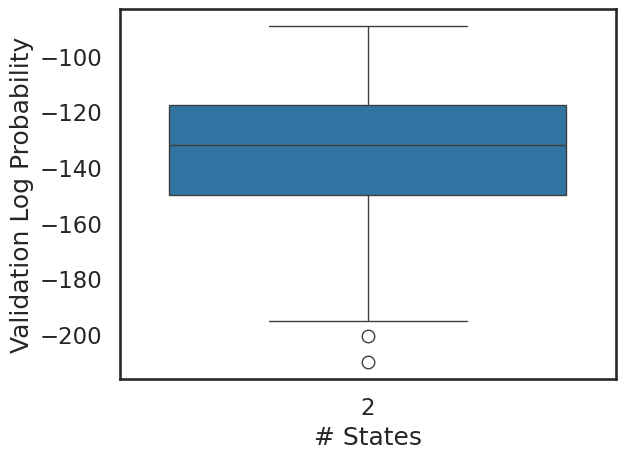

In [21]:
ax = sns.boxplot(data=cross_train.T)
ax.set_xticklabels(range(min_state, max_state))
plt.xlabel("# States")
plt.ylabel("Validation Log Probability")
# plt.savefig("validation_box.eps", format="eps")

In [22]:
# np.save("../cache/cross_valid.npy", cross_train)

In [23]:
# temp = np.load("../cache/cross_valid.npy")
# temp.shape

In [24]:
# def inspect_sample(model_idx, em_idx):
#     most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
#     posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
#     plot_emissions_and_states(train_emissions[em_idx], most_likely_states, posterior, cmap, colors)

# for i in range(2):
#     inspect_sample(5-2, i)

In [25]:
# print("transitions", p_fourth.transitions.transition_matrix)
# print("weights", p_fourth.emissions.weights)
# print("biases", p_fourth.emissions.biases)
# print("covs", p_fourth.emissions.covs)

In [26]:
model_to_check = 3

fourth = all_models[model_to_check - 2]
p_fourth = all_params[model_to_check - 2]

curr_states = model_to_check

# Plot MLE parameters:
fig = plt.figure(figsize=(12*1.5, 4*1.5), dpi=300, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
cols = colors
for k in range(curr_states):
    plt.plot(range(input_dim), p_fourth.emissions.weights[k][0], marker='o',
             color=cols[k], linestyle='-',
             lw=1.5, label="state " + str(k+1))

# for k in range(curr_states):
#     plt.plot(range(input_dim), p_fourth.emissions.weights[k][0] + p_fourth.emissions.biases[k], marker='x',
#              color=cols[k], linestyle='--', alpha = 0.5,
#              lw=1.5, label=f"state {k+1} + bias")

plt.yticks(fontsize=15)
plt.ylabel("weight", fontsize=15)
plt.xlabel("input", fontsize=15)
# plt.xticks([0, 1, 2, 3], ['target', 'coherance', 'focus', 'bias (0)'], fontsize=10, rotation=45)
plt.xticks([0, 1, 2, 3, 4], ['Calibrated \nTarget', 'High coh', 'Focused', 'Exp Ori', "Bias"], fontsize=15, rotation=0)
plt.axhline(y=0, color="k", alpha=0.5, ls="--")
# transparant boundery for legend
plt.legend(framealpha = 0, fontsize=10)
plt.title("State weights", fontsize = 15)




plt.subplot(1, 2, 2)
gen_trans_mat = p_fourth.transitions.transition_matrix
sns.heatmap(gen_trans_mat, annot=True, linewidths=1, linecolor='white')
# put the ticks 
plt.xticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
plt.yticks(np.arange(curr_states) + 0.5, np.arange(curr_states) + 1, fontsize=15)
# set font size of heatmap annotations
plt.ylabel("state t", fontsize = 15)
plt.xlabel("state t+1", fontsize = 15)
plt.title("transition matrix", fontsize = 15)

# bias = p_fourth.emissions.biases.reshape(-1).tolist()
covs = p_fourth.emissions.covs.reshape(-1).tolist()

for i in range(curr_states):
    print("| state", i+1, "| covs", covs[i], "|")
    # print("| state", i+1, "| bias", bias[i], "| covs", covs[i], "|")
    print("-"*50)

# plt.savefig("state_weights.eps", format="eps")

IndexError: list index out of range

In [ ]:
p_fourth.emissions.weights

In [ ]:
p_fourth.transitions.transition_matrix

In [ ]:
sns.heatmap(p_fourth.transitions.transition_matrix, annot=True, linewidths=1, linecolor='white')

In [ ]:
tw = p_fourth.transitions.transition_weights

In [ ]:
tw

In [ ]:
sns.lineplot(tw.T)

In [ ]:
model_to_check, test_obs.shape

In [ ]:
model_idx = model_to_check-2
all_posteriors = []

for em_idx in range(train_emissions.shape[0]):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], train_emissions[em_idx], inputs=train_inputs[em_idx])
    all_posteriors.append(posterior.predicted_probs)

In [ ]:
avg_sess = np.array(all_posteriors).mean(axis=0)
std_sess = np.array(all_posteriors).std(axis=0)

avg_sess.shape, std_sess.shape

In [ ]:
plt.figure(figsize=(6, 4))

K = model_to_check
total_sessions = train_emissions.shape[0]

for k in range(K):
    plt.plot(avg_sess[:, k], label="State " + str(k + 1), lw=1,
                color=cols[k])
    se = std_sess[:, k] / np.sqrt(total_sessions)
    plt.plot(avg_sess[:, k] + se, color=cols[k], alpha=0.3)
    plt.plot(avg_sess[:, k] - se, color=cols[k], alpha=0.3)

# plt.xticks([0, 45, 90], ["", "", ""], fontsize=15)
# plt.yticks([0, 0.5, 1], ["", "", ""], fontsize=15)
plt.ylim((-0.01, 1.01))
plt.title(f"Avg. Session (total {total_sessions} sess)", fontsize=15)
plt.xlabel("trial #", fontsize=15)
plt.ylabel("p(state)", fontsize=15)
plt.legend(fontsize=15, framealpha=0)
# plt.gca().spines['right'].set_visible(False)
# plt.gca().spines['top'].set_visible(False)
# plt.xticks([0, 45, 90, 120], ["0", "45", "90", "120"], fontsize=15)
# plt.yticks([0, 0.5, 1], ["0", "0.5", "1"], fontsize=15)

# plt.savefig("avg_sess.eps", format="eps")

In [ ]:
def inspect_sample(model_idx, em_idx):
    most_likely_states = all_models[model_idx].most_likely_states(all_params[model_idx], test_obs[em_idx], inputs=test_design[em_idx])
    posterior = all_models[model_idx].smoother(all_params[model_idx], test_obs[em_idx], inputs=test_design[em_idx])
    plot_emissions_and_states(test_obs[em_idx], test_design[em_idx], most_likely_states, posterior, cmap, colors)

for i in range(1):
    inspect_sample(model_to_check-2, i)



In [ ]:
from tensorflow_probability.substrates import jax as tfp
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions


In [ ]:
wts = p_fourth.emissions.weights
cvs = p_fourth.emissions.covs

In [ ]:
wts.shape, cvs.shape

In [ ]:
# make 3, 1 plot
designs = ['Calibrated \nTarget', 'High coh', 'Focused', 'Exp Ori', "Bias"]

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i in range(3):
    ax = axs[i]

    curr_wt = wts[i][0]
    curr_vr = cvs[i]
    
    for idx, name in enumerate(designs):
    
        # ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.5)
        
        dst = tfd.VonMises(curr_wt[idx], 1/curr_vr[idx])
        x = np.linspace(-np.pi, np.pi, 1000)
        y = dst.cdf(x)


        ax.plot(x, y, label=name)

        # put mean in the plot and the y axis
        ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.2)

    ax.set_title(f"State {i+1}")
    ax.set_ylabel("Cumulative Density")

    # # give space between subplots
    # plt.subplots_adjust(hspace=0.5)

    # Only show ticks on the last plot
    if i == 2:
        ax.set_xlabel("Values")
    else:
        ax.set_xticks([])

    # combine all x axis to bottom
    # ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    # ax.set_xticklabels(["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
        
    ax.set_yticks([0, 0.25, 0.5,0.75, 1])
    ax.set_yticklabels(["0%", "25%", "50%", "75%", "100%"])

    # put legend outside on the top right
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# plt.savefig("state_cdf.eps", format="eps")

In [ ]:
curr_wt

In [ ]:
# Now do almost the same for pdf

fig, axs = plt.subplots(3, 1, figsize=(8, 16))

for i in range(3):
    ax = axs[i]

    curr_wt = wts[i][0]
    curr_vr = cvs[i]
    
    for idx, name in enumerate(designs):
    
        # ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.5)
        
        dst = tfd.VonMises(curr_wt[idx], 1/curr_vr[idx])
        x = np.linspace(-np.pi, np.pi, 1000)
        y = dst.prob(x)


        ax.plot(x, y, label=name)

        # put mean in the plot and the y axis
        ax.axvline(curr_wt[idx], color='k', linestyle='--', alpha=0.2)

    ax.set_title(f"State {i+1}")
    ax.set_ylabel("Probability Density")

    # give space between subplots
    plt.subplots_adjust(hspace=0.5)

    # Only show ticks on the last plot
    if i == 2:
        ax.set_xlabel("Values")
    # else:
    #     ax.set_xticks([])
        
    # mark the mean on x axis
    ax.set_xticks(curr_wt)
    ax.set_xticklabels([str(x)[:4] for x in curr_wt], rotation=45)


    # put legend outside on the top right
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# plt.savefig("state_pdf.eps", format="eps")

In [ ]:
g = sns.displot(data=penguins, x="flipper_length_mm", y="bill_length_mm", kind="kde", rug=True)

In [ ]:
from tensorflow_probability.substrates import jax as tfp
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions

dst = tfd.VonMises(loc=0, concentration=1)

data = dst.sample(1000, seed=jr.PRNGKey(1))


# # plot the pdf
# x = np.linspace(-np.pi, np.pi, 100)
# plt.plot(x, dst.prob(x))

# # plot the cdf
# plt.plot(x, dst.cdf(x))

# check = 5 # radiance

# # plot this on the graph as probability of value 5
# plt.plot(np.linspace(np.pi, np.pi *2, 100), dst.prob(np.linspace(np.pi, np.pi *4, 100)), '--')

# plt.plot(np.linspace(np.pi, np.pi *2, 100), dst.cdf(np.linspace(np.pi, np.pi *4, 100)), '--')

